In [1]:
import os
import pywt
import glob
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-07-07 09:18:10.628616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 09:18:13.737640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data and preprocess

In [2]:
xTrain = np.load("./xTrain.npy")
yTrain = np.load("./yTrain.npy", allow_pickle=True)

xTest = np.load("./xTest.npy")
yTest = np.load("./yTest.npy", allow_pickle=True)

In [3]:
# remove sheath
ixTrain = np.where(yTrain != 4)
ixTest = np.where(yTest != 4)

xTrain = xTrain[ixTrain,:]
xTest = xTest[ixTest,:]

yTrain = yTrain[ixTrain]
yTest = yTest[ixTest]

xTrain = xTrain[0,:,:]
xTest = xTest[0,:,:]

In [4]:
# Columns are:
#
# 0 = 'Beta_p'
# 1 = 'Va'
# 2 = 'Tratio'
# 3 = 'entropy'
# 4 = 'crossHelicity'
# 5 = 'residualEnergy'
# 6 = 'TotalPressure'
# 7 = 'bFluctuations'

In [4]:
nClasses = len( np. unique( yTrain ) )
nClasses

4

In [5]:
y = tf.one_hot(yTrain,nClasses)

2024-07-07 09:18:33.031793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5337 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:65:00.0, compute capability: 3.5


### Neural Network

In [23]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

In [6]:
def create_probablistic_bnn_model(rows,columns):
    
    inputs = tf.keras.layers.Input(shape=columns)
    
    hidden1 = tf.keras.layers.Dense(16, activation='relu')(inputs)    
    hidden2 = tf.keras.layers.Dense(8, activation='relu')(hidden1)
    
    distribution_params = layers.Dense(nClasses)(hidden2)
    outputs = tfp.layers.OneHotCategorical(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [7]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [10]:
bnn = create_probablistic_bnn_model(xTrain.shape[0],xTrain.shape[1])
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 one_hot_categorical (OneHot  ((None, 4),              0         
 Categorical)                 (None, 4))                         
                                                                 
Total params: 300
Trainable params: 300
Non-trainable params: 0
_______________________________________________________________

In [12]:
bnn.compile( loss=negative_loglikelihood, metrics=['accuracy'] )

In [13]:
history = bnn.fit( xTrain, y, epochs=200, verbose=1, 
                  use_multiprocessing=True, validation_split=0.2)

Epoch 1/200


2024-06-21 10:23:28.462780: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x752460023ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-21 10:23:28.462832: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN Black, Compute Capability 3.5
2024-06-21 10:23:28.469237: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-21 10:23:30.474754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-06-21 10:23:31.061958: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-21 10:23:31.372794: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


980/980 [==============================] - 61s 51ms/step - loss: 1.2630 - accuracy: 0.3010 - val_loss: 1.1648 - val_accuracy: 0.3406
Epoch 2/200
980/980 [==============================] - 49s 50ms/step - loss: 0.9961 - accuracy: 0.4149 - val_loss: 0.8322 - val_accuracy: 0.4838
Epoch 3/200
980/980 [==============================] - 51s 52ms/step - loss: 0.7257 - accuracy: 0.5517 - val_loss: 0.6433 - val_accuracy: 0.5994
Epoch 4/200
980/980 [==============================] - 49s 50ms/step - loss: 0.5917 - accuracy: 0.6307 - val_loss: 0.5442 - val_accuracy: 0.6659
Epoch 5/200
980/980 [==============================] - 49s 50ms/step - loss: 0.5169 - accuracy: 0.6803 - val_loss: 0.4974 - val_accuracy: 0.7055
Epoch 6/200
980/980 [==============================] - 49s 50ms/step - loss: 0.4726 - accuracy: 0.7105 - val_loss: 0.4581 - val_accuracy: 0.7221
Epoch 7/200
980/980 [==============================] - 48s 49ms/step - loss: 0.4436 - accuracy: 0.7346 - val_loss: 0.4421 - val_accuracy: 0.74

980/980 [==============================] - 49s 50ms/step - loss: 0.2295 - accuracy: 0.8731 - val_loss: 0.2330 - val_accuracy: 0.8684
Epoch 114/200
980/980 [==============================] - 49s 50ms/step - loss: 0.2296 - accuracy: 0.8731 - val_loss: 0.2409 - val_accuracy: 0.8757
Epoch 115/200
980/980 [==============================] - 49s 50ms/step - loss: 0.2295 - accuracy: 0.8737 - val_loss: 0.2383 - val_accuracy: 0.8736
Epoch 116/200
980/980 [==============================] - 49s 50ms/step - loss: 0.2286 - accuracy: 0.8732 - val_loss: 0.2295 - val_accuracy: 0.8720
Epoch 117/200
980/980 [==============================] - 49s 50ms/step - loss: 0.2288 - accuracy: 0.8735 - val_loss: 0.2490 - val_accuracy: 0.8628
Epoch 118/200
980/980 [==============================] - 49s 50ms/step - loss: 0.2285 - accuracy: 0.8726 - val_loss: 0.2409 - val_accuracy: 0.8726
Epoch 119/200
980/980 [==============================] - 47s 48ms/step - loss: 0.2269 - accuracy: 0.8744 - val_loss: 0.2444 - val_ac

Epoch 169/200
980/980 [==============================] - 50s 51ms/step - loss: 0.2220 - accuracy: 0.8776 - val_loss: 0.2458 - val_accuracy: 0.8744
Epoch 170/200
980/980 [==============================] - 49s 50ms/step - loss: 0.2206 - accuracy: 0.8785 - val_loss: 0.2213 - val_accuracy: 0.8681
Epoch 171/200
980/980 [==============================] - 49s 50ms/step - loss: 0.2207 - accuracy: 0.8818 - val_loss: 0.2283 - val_accuracy: 0.8805
Epoch 172/200
980/980 [==============================] - 48s 49ms/step - loss: 0.2212 - accuracy: 0.8786 - val_loss: 0.2232 - val_accuracy: 0.8778
Epoch 173/200
980/980 [==============================] - 49s 50ms/step - loss: 0.2206 - accuracy: 0.8810 - val_loss: 0.2590 - val_accuracy: 0.8647
Epoch 174/200
980/980 [==============================] - 49s 50ms/step - loss: 0.2209 - accuracy: 0.8816 - val_loss: 0.2331 - val_accuracy: 0.8780
Epoch 175/200
980/980 [==============================] - 48s 49ms/step - loss: 0.2209 - accuracy: 0.8759 - val_loss: 0

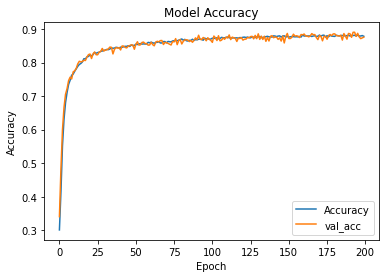

In [14]:
plt.plot( history.history['accuracy'], label="Accuracy")
plt.plot( history.history['val_accuracy'], label="val_acc")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

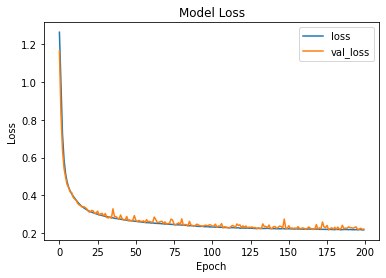

In [15]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [16]:
# serialize weights to HDF5
bnn.save_weights("./model_weights_8PNN_no_sheath.h5")

In [17]:
from scipy.stats import entropy

preds = []
p = bnn( xTest )
en = bnn( xTest ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )

In [19]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 24}
plt.rc('font', **font)

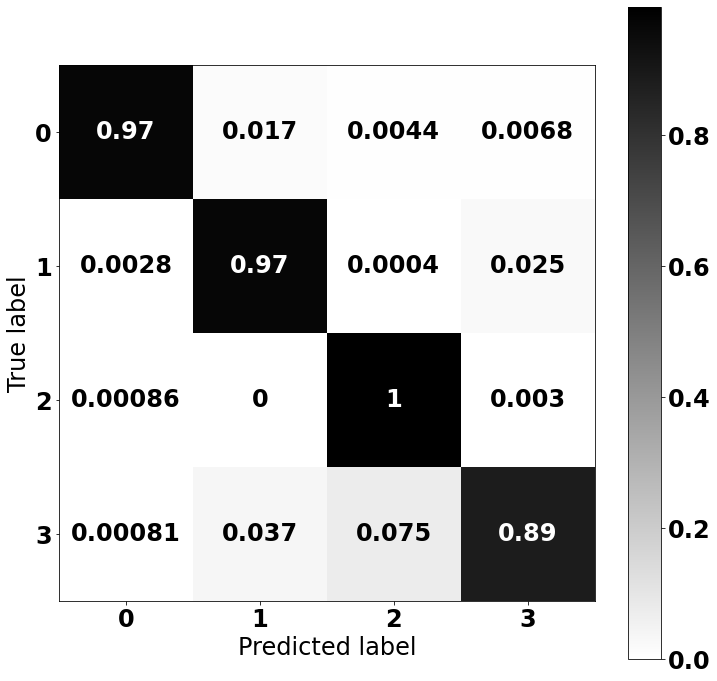

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 12))

cm = confusion_matrix( yTest.astype(int), preds, normalize='true' )
disp = ConfusionMatrixDisplay( confusion_matrix=cm )
disp.plot(ax=ax, cmap='gist_yarg')

In [35]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

yTest = yTest.astype(int)

print( "Macro F1:", np.round( f1_score(yTest, preds, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(yTest, preds, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(yTest, preds, average='macro'), 4 ))
print( "Accuracy:", np.round( accuracy_score(yTest, preds), 4 ))

Macro F1: 0.9559
Macro Precision: 0.9567
Macro Recall: 0.9567
Accuracy: 0.9562


### If model is already trained - Load the saved model for analysis

In [8]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

bnn = create_probablistic_bnn_model( xTest.shape[0], xTest.shape[1] )
 
# load weights into new model
bnn.load_weights("./model_weights_8PNN_no_sheath.h5")

In [9]:
from scipy.stats import entropy

p = bnn(xTest)
en = bnn(xTest).entropy()
preds = []

for i in range( xTest.shape[0] ):
    preds.append( np.argmax(p[i,:]) )